# Abstract
In this blog post I will demonstrate the "double descent" phenomeon that occurs when the number of features is much greater than the number of points in a dataset. This phenomenon is supposedly the reason why deep learning outperforms traditional machine learning. By increasing the number of features, the MSE on testing data rises sharply before a certain threshold known as the interpolation threshold before the MSE values go back down and can actually be lower than the values gotten before passing the interpolation threshold. 

# Part 0: Why Closed-Form MSE does not work when number of parameters > number of points
dThe reason that we cannot compute the closed-form of equation 1 if p > n is because XTX is not invertible, so the operation (XTX)-1 would fail. This is because matrices that are not full-rank are not invertible. We know that XTX is not full rank because X is an nxp matrix, and the maximum possible rank of a matrix is limited by its smallest dimension (which in this case is n). The dimensions of XTX are pxp, however its rank is strictly less than or equal to n, which is less than the number of columns in the matrix p. That means that the matrix XTX rank cannot possibly equal its number of columns, making the matrix not full rank and not invertible. 

# Part 1: Implementing overparameterized LinearRegression Model
We will implement a variation of the linear regression model that will instead use the Moore-Penrose ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pseudoinverse of X to calculate the optimal weight vector value, as it can be computed when the number of parameters p is greater than the number of points n. We will use this model to demonstrate double descent.

In [37]:
import torch

class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        """
        Compute the scores for each data point in the feature matrix X. 
        The formula for the ith entry of s is s[i] = <self.w, x[i]>. 

        If self.w currently has value None, then it is necessary to first initialize self.w to a random value. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            s torch.Tensor: vector of scores. s.size() = (n,)
        """
        if self.w is None: 
            self.w = torch.rand(X.size()[1])
        return X@self.w

    def predict(self, X):
        """
        Compute the predictions for each data point in the feature matrix X. The prediction for the ith data point is either 0 or 1. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            y_hat, torch.Tensor: vector predictions in {0.0, 1.0}. y_hat.size() = (n,)
        """
        scores = self.score(X)
        return torch.where(scores >= 0, torch.tensor(1.0), torch.tensor(0.0))

class MyLinearRegression(LinearModel):
    def predict(self, X):
        return self.score(X)
    
    def loss(self, X, y):
        error = (y - self.score(X))
        return torch.pow(error, 2).mean()
        

class OverParameterizedLinearRegressionOptimizer:
    def __init__(self, model):
        self.model = model

    def fit(self,X,y):
        self.model.w = torch.linalg.pinv(X) @ y
        return

# Part 2: Demonstration on Simple Data
We will now see how this overparamterized linear regression fits to random nonlinear data. Below is the data in question.

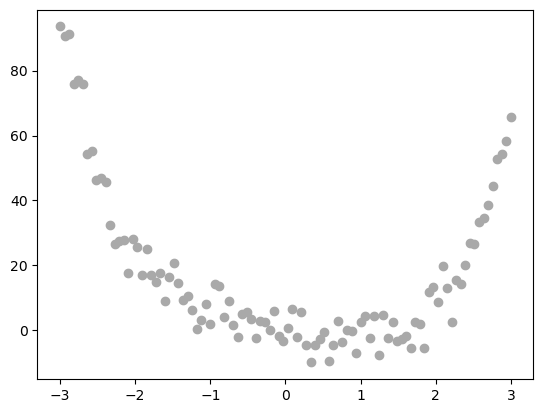

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')

# How will model fit to nonlinear data?
With the class below, we apply a feature map to X in order to allow it to fit to nonlinear data instead of simply producing a linear line of best fit.

In [ ]:
import torch

def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

# Putting it All Together
Now, we use our RandomFeatures class, which we can specify how many features to use, and then fit and transform our X feature matrix in order to have nonlinearity. Through plotting the predictions made by the model after fitting, we can see that the model does well capturing the trend of this nonlinear data.

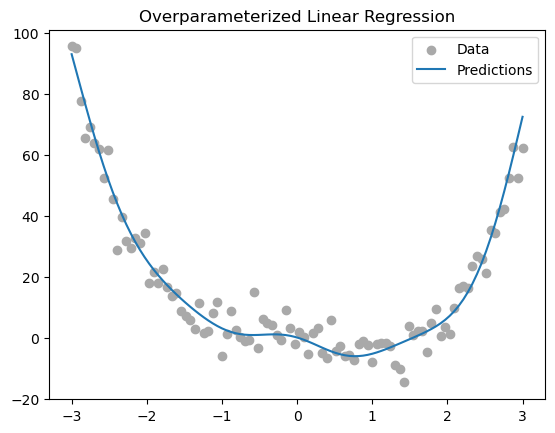

In [ ]:
phi = RandomFeatures(n_features = 10)
phi.fit(X)
X_train_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_train_features, y)

X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)
y_pred = LR.predict(X_train_features)

plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X, y_pred, label="Predictions")
plt.title("Overparameterized Linear Regression")
plt.legend()
plt.show()

# Part C: Double Descent In Image Corruption Detection
Now we will demonstrate overfitting and double descent with an image corruption machine learning task.

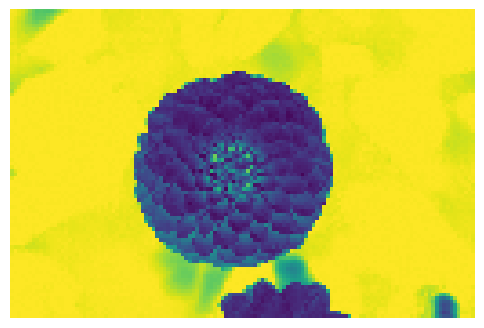

In [26]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

In [28]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

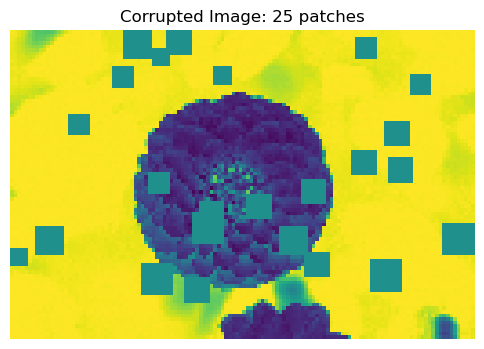

In [30]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In [31]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

In [32]:
from sklearn.model_selection import train_test_split
X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [62]:
num_iterations = 200
mse_training, mse_testing = [], []
best_testing_error = [float('inf'), 0]
for i in range(200):
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)

    phi = RandomFeatures(n_features = i, activation=square)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    opt.fit(X_train_phi, y_train)
    
    cur_mse_training = LR.loss(X_train_phi, y_train).item()
    cur_mse_testing = LR.loss(X_test_phi, y_test).item()

    if(cur_mse_testing < best_testing_error[0]):
        best_testing_error[0] = cur_mse_testing
        best_testing_error[1] = i

    mse_training.append(cur_mse_training)
    mse_testing.append(cur_mse_testing)

In [63]:
print(f"Best training mse: {best_testing_error[0]:4f}\nNumber of features: {best_testing_error[1]}")

Best training mse: 362.604440
Number of features: 187


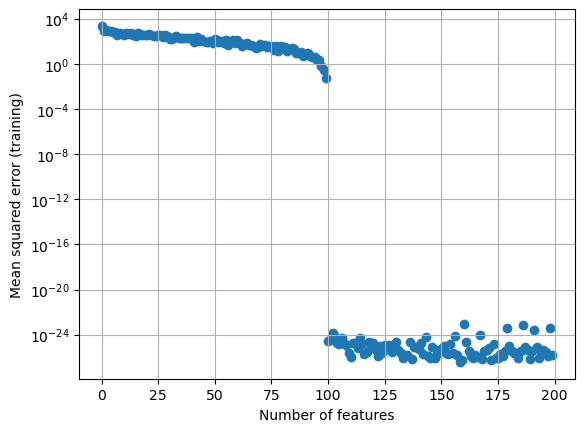

In [ ]:
x_axis = [x for x in range(200)]
plt.scatter(x_axis, mse_training)
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (training)")
plt.yscale('log')
plt.grid()
plt.show()

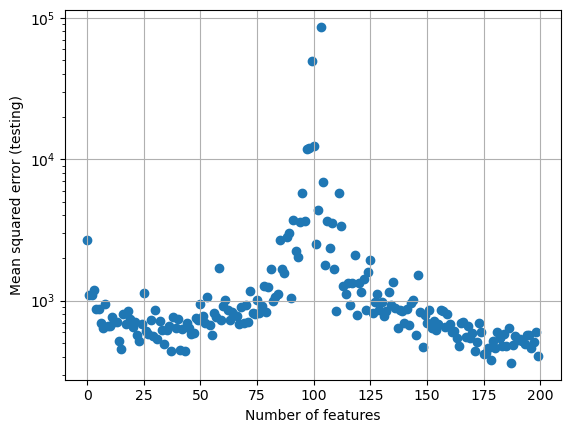

In [65]:
x_axis = [x for x in range(200)]
plt.scatter(x_axis, mse_testing)
plt.xlabel("Number of features")
plt.ylabel("Mean squared error (testing)")
plt.yscale('log')
plt.grid()
plt.show()

# Closing Discussion
Through these various experiments, I learned at a high level how deep learning outpreforms traditional machine learning by taking advantage of the "double descent" phenomenon. I also learned through practice how feature matrices allow machine learning models to fit to nonlinear data, and how the use of feature maps is at the heart of deep learning, as it allows for overparameterization that can lead to optimal model performance past the interpolation threshold.